In [212]:
# P1, Initialising
#various imported libraries, some may be unused
#filenames may be irrelevant depending on who is accessing or what is available
import matplotlib.transforms as mtransforms
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import pickle
import os
from scipy.optimize import curve_fit
from astropy.io import fits
import pandas as pd
from astropy.utils.data import download_file
import statistics
from scipy.stats import powerlaw
from scipy.stats import iqr
import operator 
np.set_printoptions(threshold=np.nan)


In [213]:
#depending on where the files are located, the cd command can work out of a specified directory 
#cd C:\Users\roryf

C:\Users\roryf\Downloads\2nd Sem Swin\Grand Challenges\working


In [215]:
#FITS file reader function 
def rSDSSFITS(FITSfile):
    with fits.open(FITSfile) as hdulist:
        #allows for easy access of different headers from the FITS file. For DR14, the lite versions were sufficient. 
        (h0,d0,h1,d1,d2,h2)=(hdulist[0].header,hdulist[0].data,hdulist[1].header,hdulist[1].data,hdulist[2].data,hdulist[2].header)
        #flux array in angstrom
        lw=d1['loglam']
        #wavelength array in angstrom
        wl=np.power(10.0,lw)
        #the inverse variance array which corresponds to each wavelength value (for each pixel)
        invaris=np.array(d1['ivar'])
        #assignszeroes in ivar array as -inf
        sig=np.empty((len(invaris)))
        for j in range(0,len(invaris)):
            sig[j]=np.reciprocal(np.sqrt(invaris[j])) if (invaris[j]>0.0) else -np.inf
    #Returned variables 
    return {'wl':wl,'sig':sig,'lw':lw,'fl':d1['flux'],'er':d1[2],'invaris':invaris,'h0':h0,'d0':d0,'d1':d1,'h1':h1,'h2':h2,'d2':d2}


No handles with labels found to put in legend.
C:\Users\roryf\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


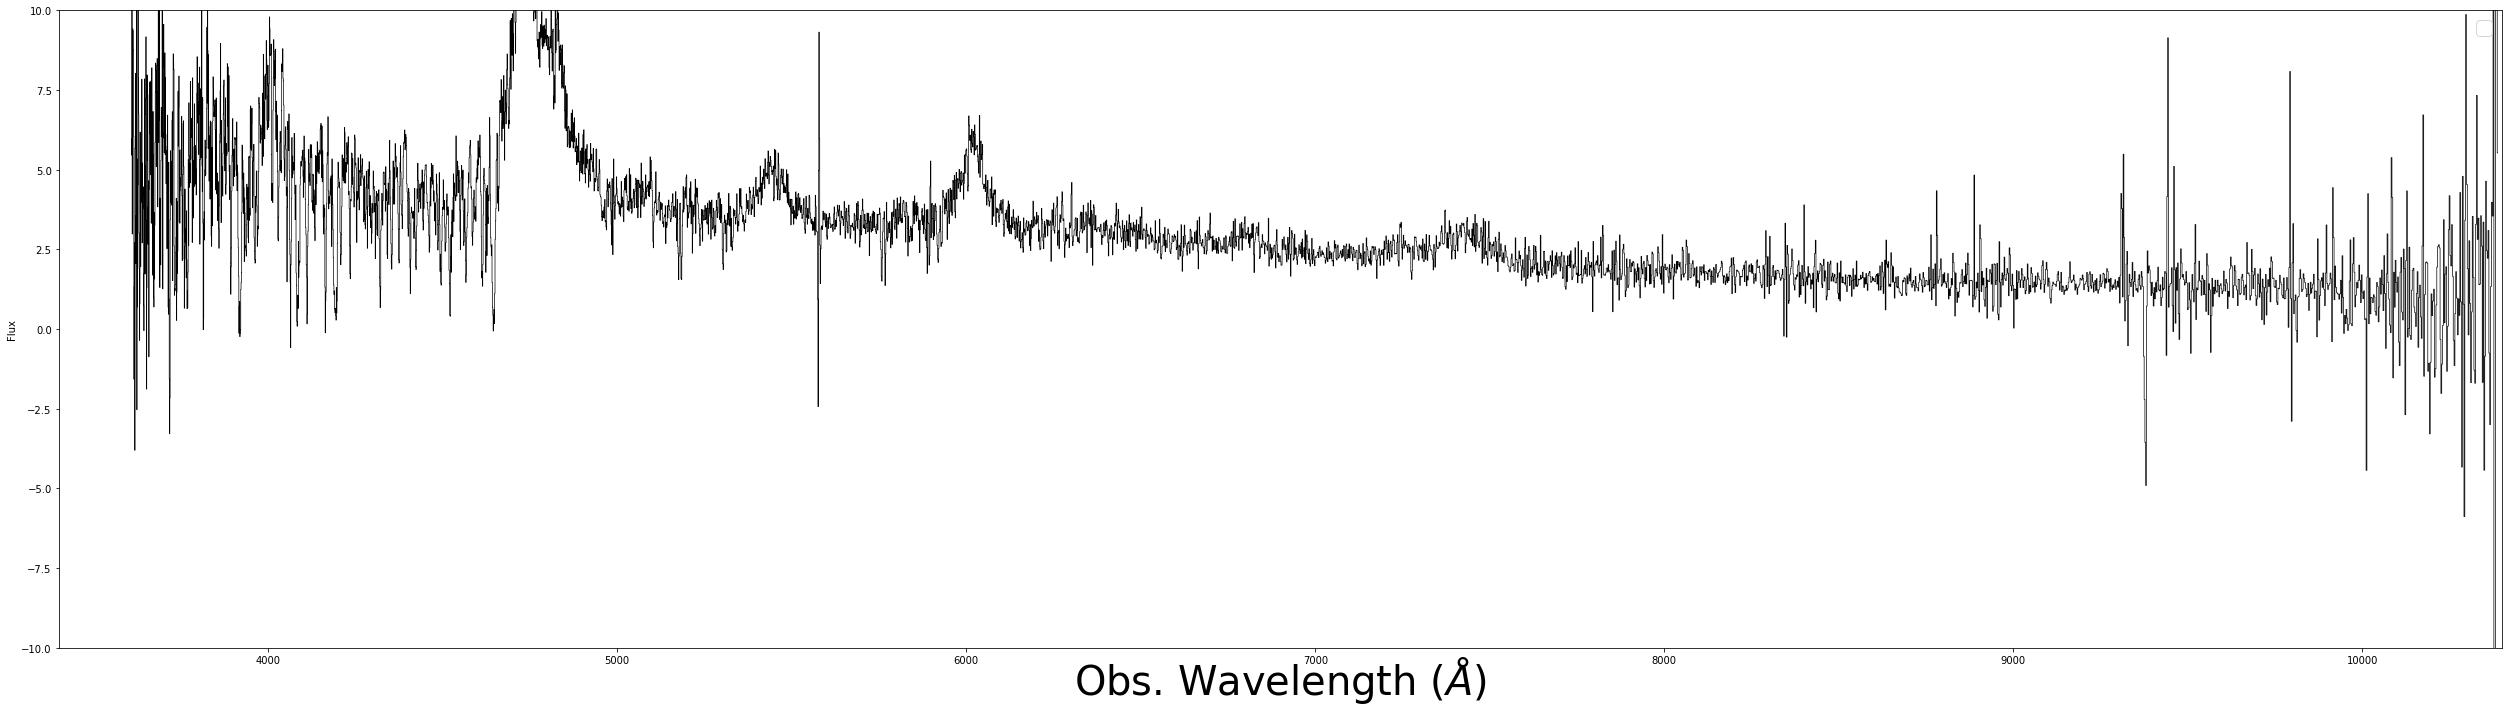

In [224]:
#Basic plotting of a spectrum with various additions, would serve to plot using preferred formatting instead. 
fig=plt.figure(figsize=(35,10.0))
x=s['wl']
y=np.array(s['fl'])
z=s['z']
z1=z+1
xr=x/(1+z)
myc={'violet':'#6E36BB','blue':'#2480D0','cyan':'#00E6E6','green':'#44AA99',
     'orange':'#EC9800','red':'#A00620','black':'#000000'}
ax1 = fig.add_subplot(111)

xmin1,xmax1=s['wl'][0],s['wl'][-1]

ax1.step(x,y,where='mid',lw=.7,color=myc['black'],alpha=2,rasterized=True)
ax1.set_ylabel(r'Flux',ha='center',va='bottom')
ax1.set_xlabel(r'Obs. Wavelength ($\AA$)',ha='center',size=40,va='bottom',labelpad=40)
ax1.set_xlim(3400,10400)
ax1.set_ylim(-10,10)
plt.legend(loc=1, prop={'size': 20})
ax1 = fig.add_subplot(111)
#plt.savefig("figureb10.png")
fig.subplots_adjust(left=0.05,right=0.99,bottom=0.10,top=0.99,wspace=0,hspace=0)
fig.tight_layout()

In [225]:
#spectral bands in rest wavelengths converted to obs [upper,lower]
#ospre=np.array(([5385.32227,5452.849824],[5545.700208,5604.786816],[5676.53484,5748.282864],[6056.37732,6182.99148],[7107.274848,7174.8024]))
#The median values of the 5 spectral regions,the same for all quasar spectra (observed wavelength)
medspreg=np.array([1284.0, 1321.0, 1353.5, 1450.0, 1692.0])
ospre=np.array([[1276,1292],[1314,1328],[1345,1362],[1435,1465],[1684,1700]])
zospre=ospre*z1
zmedspreg=medspreg*z1
#spectral bands in observed wavelengths
fval=[]
for i in range(0,5):
    g1=y[(x>=zospre[i][0]) & (x<=zospre[i][1])]
    fval.append(g1)
#interquartile values for flux
iqrval=[]
for i in range(0,5):
    g2=iqr(fval[i],rng=(25,75))
    iqrval.append(g2)
#median values for flux   
fmed=[]
for i in range(0,5):
    g3=np.median(fval[i])
    fmed.append(g3)

No handles with labels found to put in legend.


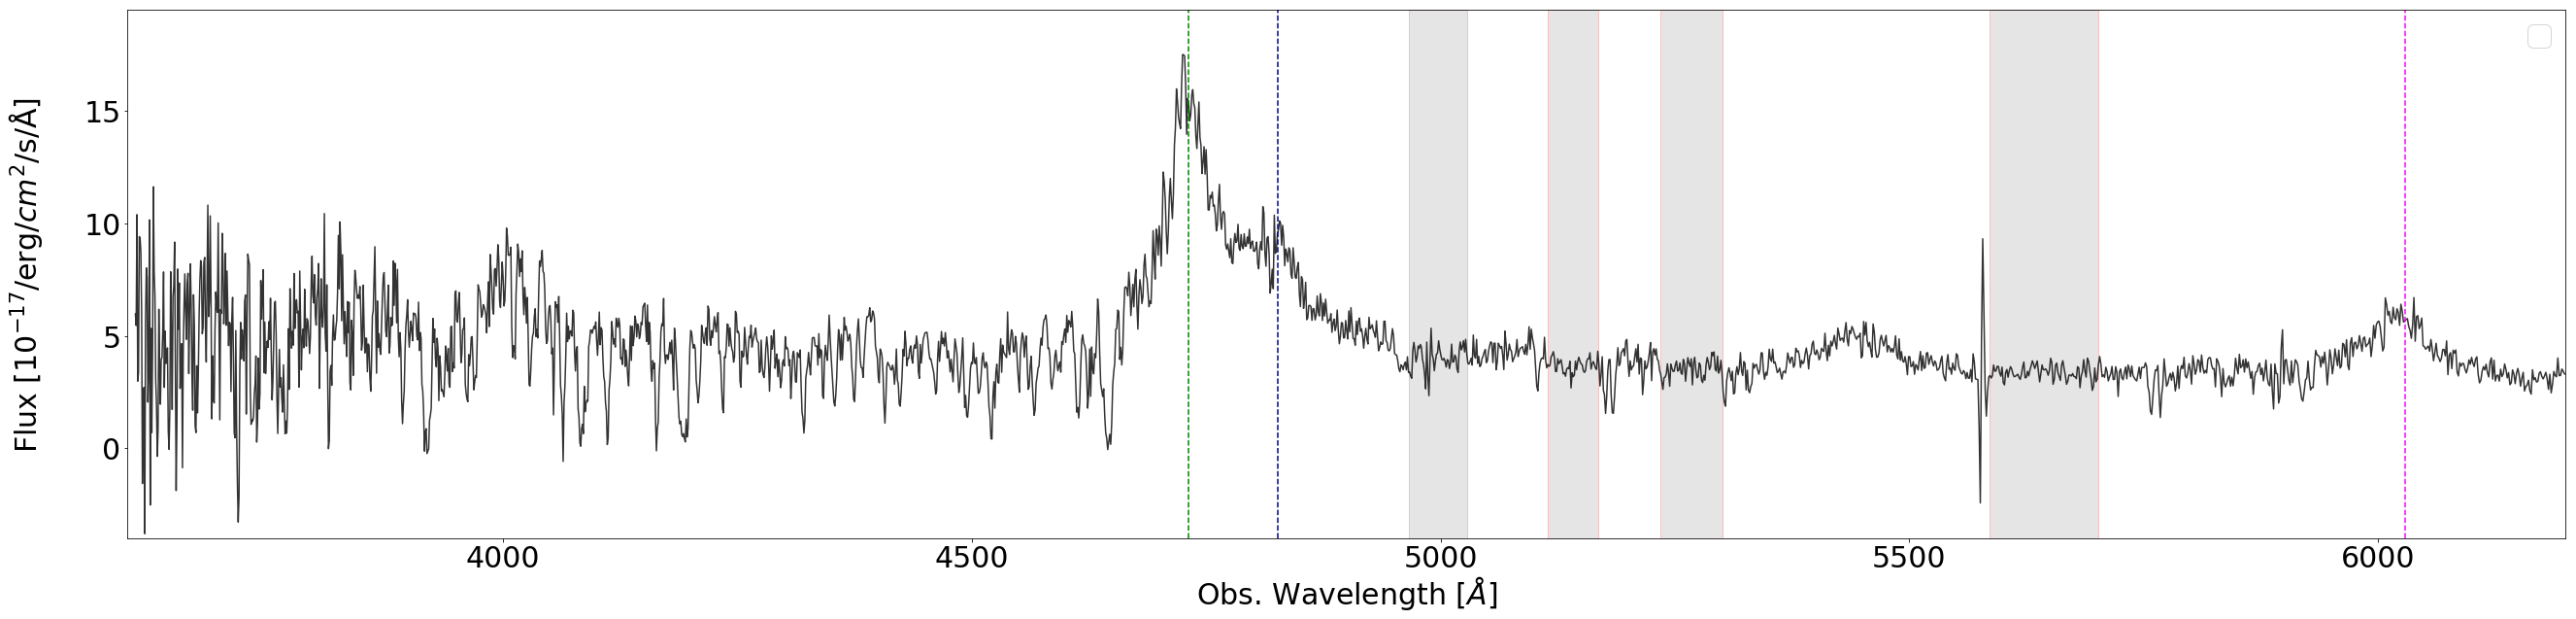

In [228]:
#curve fit (for beta determination) and replotting of input spectrum
from pylab import *
def func_powerlaw(lam, m, c):
    return c*lam**m

X=zmedspreg
Y=fmed
popt, pcov = curve_fit(func_powerlaw,X,Y,sigma=iqrval,maxfev=130000)
plt.figure(figsize=(45, 10))
plt.plot(X,func_powerlaw(X, *popt), '-',label='Fitted power-law',linewidth=7)
plt.plot(x,y,'k-',rasterized=True,alpha=0.8)
plt.plot(X, Y, 'ro',label='Median flux values',markersize=12)
ymax=19.5
ymin=-4
matplotlib.pyplot.ylim(ymin, ymax)
#matplotlib.pyplot.xlim(.86*zospre[0][0],zospre[4][1]*1.02)
matplotlib.pyplot.xlim(3600,6200)
plt.xlabel(r'Obs. Wavelength [$\AA$]',size=30,ha='center',va='bottom',labelpad=40)
plt.ylabel(r'Flux [$10^{-17}$/erg/$cm^2$/s/Å]',size=30,ha='center',va='bottom',labelpad=40)
ax2 = ax1.twiny()
plt.axvline(x=z1*(1240),linestyle='--',color='navy')
#Nitrogen V
plt.axvline(x=z1*(1549),linestyle='--',color='magenta')
#Carbon IV
plt.axvline(x=z1*(1215.6701),linestyle='--',color='green')
#Lya line

plt.legend(loc=1, prop={'size': 30})
plt.xticks(fontsize=30,)
plt.yticks(fontsize=30,)
#shaded 'quiet' spectral regions
fill([zospre[0][0],zospre[0][1],zospre[0][1],zospre[0][0]], [ymin,ymin,ymax,ymax], 'grey', alpha=0.2, edgecolor='r')
fill([zospre[1][0],zospre[1][1],zospre[1][1],zospre[1][0]], [ymin,ymin,ymax,ymax], 'grey', alpha=0.2, edgecolor='r')
fill([zospre[2][0],zospre[2][1],zospre[2][1],zospre[2][0]], [ymin,ymin,ymax,ymax], 'grey', alpha=0.2, edgecolor='r')
fill([zospre[3][0],zospre[3][1],zospre[3][1],zospre[3][0]], [ymin,ymin,ymax,ymax], 'grey', alpha=0.2, edgecolor='r')
fill([zospre[4][0],zospre[4][1],zospre[4][1],zospre[4][0]], [ymin,ymin,ymax,ymax], 'grey', alpha=0.2, edgecolor='r')
plt.savefig("BADDR14.png")
plt.show()